# Exploratory Data Analysis (EDA)

## Overview
Initial exploration of the Metrofleet taxi trip dataset to understand data distributions, relationships, and quality.

## Objectives
- Load and inspect trip data from the data warehouse
- Analyze distributions of key metrics (distance, fare, time)
- Identify correlations between variables
- Establish baseline understanding for subsequent analyses

In [1]:
import os

import matplotlib.pyplot as plt
import polars as pl
import seaborn as sns

# Set style for better visuals
sns.set_style('whitegrid')
plt.rcParams['figure.dpi'] = 100
plt.rcParams['font.size'] = 10

In [2]:
# 1. Connection Config
# Polars prefers a direct URI string over a SQLAlchemy engine object
uri = f"postgresql://{os.getenv('POSTGRES_USER')}:{os.getenv('POSTGRES_PASSWORD')}@{os.getenv('POSTGRES_HOST')}:5432/{os.getenv('POSTGRES_DB')}"

In [3]:
# 2. Load Data (Lazy is not supported for DB read yet, but eager is very fast)
# We sample significantly more data than Pandas could handle easily
query = """
SELECT 
    pickup_location_id,
    dropoff_location_id,
    pickup_datetime,
    trip_distance,
    total_amount
FROM dbt_dev.fct_trips
WHERE total_amount > 0 
  AND total_amount < 200 
  AND trip_distance > 0
LIMIT 500000
"""

print("Loading data with Polars...")
df = pl.read_database_uri(query=query, uri=uri, engine="connectorx")
print(f"Loaded {df.height} rows.")

Loading data with Polars...
Loaded 500000 rows.


## Feature Engineering

Extract temporal features from pickup timestamps for time-based analysis.

In [4]:
# 3. Feature Engineering (The Polars Way)
# Using Polars expressions is much faster than .apply()
df_clean = df.with_columns([
    pl.col("pickup_datetime").dt.hour().alias("pickup_hour"),
    pl.col("pickup_datetime").dt.weekday().alias("pickup_day"), # 1=Mon, 7=Sun
    # Calculate approx duration if you had dropoff_time, or any other FE
])

## Correlation Analysis

Examine relationships between numeric variables to identify patterns and dependencies.

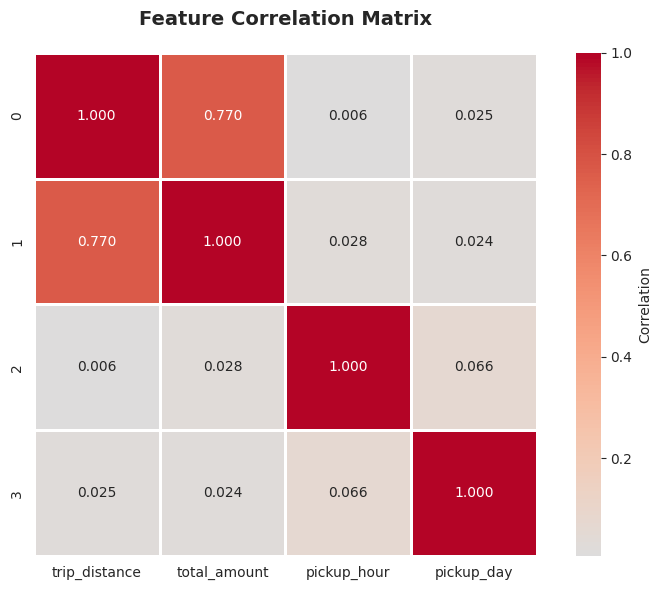

In [5]:
corr_df = df_clean.select(["trip_distance", "total_amount", "pickup_hour", "pickup_day"]).corr().to_pandas()

plt.figure(figsize=(8, 6))
sns.heatmap(corr_df, annot=True, fmt='.3f', cmap='coolwarm', center=0, 
            square=True, linewidths=1, cbar_kws={'label': 'Correlation'})
plt.title('Feature Correlation Matrix', fontsize=14, fontweight='bold', pad=20)
plt.tight_layout()
plt.show()

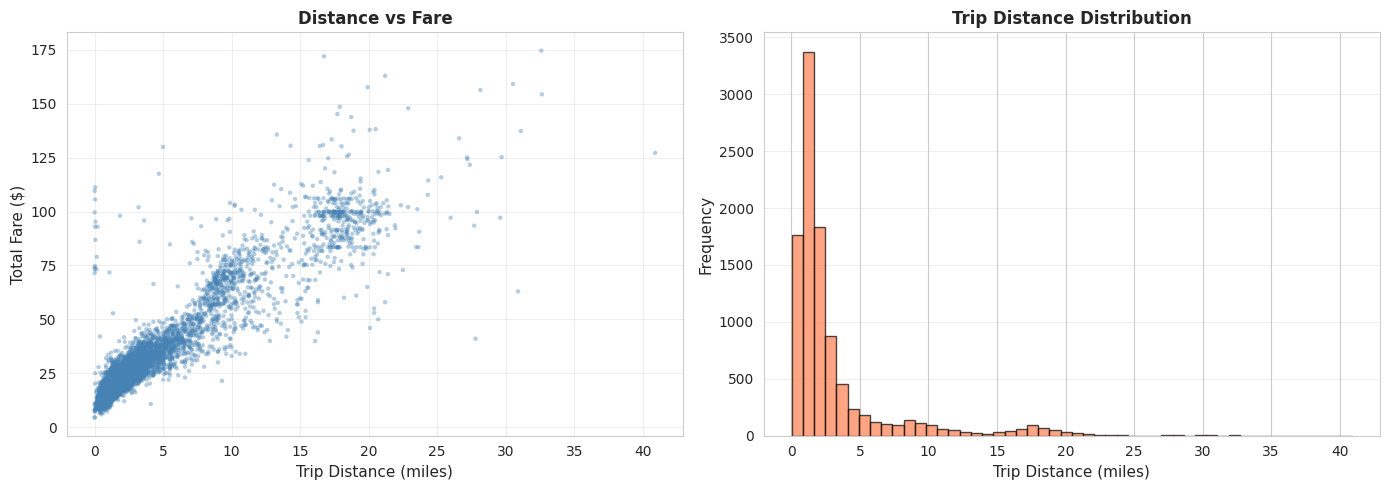

In [6]:
# Distance vs Fare Relationship
plot_data = df_clean.sample(10000).to_pandas()

fig, axes = plt.subplots(1, 2, figsize=(14, 5))

# Scatter plot
axes[0].scatter(plot_data['trip_distance'], plot_data['total_amount'], 
                alpha=0.4, s=10, c='steelblue', edgecolors='none')
axes[0].set_xlabel('Trip Distance (miles)', fontsize=11)
axes[0].set_ylabel('Total Fare ($)', fontsize=11)
axes[0].set_title('Distance vs Fare', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3)

# Distribution plots
axes[1].hist(plot_data['trip_distance'], bins=50, alpha=0.7, color='coral', edgecolor='black')
axes[1].set_xlabel('Trip Distance (miles)', fontsize=11)
axes[1].set_ylabel('Frequency', fontsize=11)
axes[1].set_title('Trip Distance Distribution', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3, axis='y')

plt.tight_layout()
plt.show()

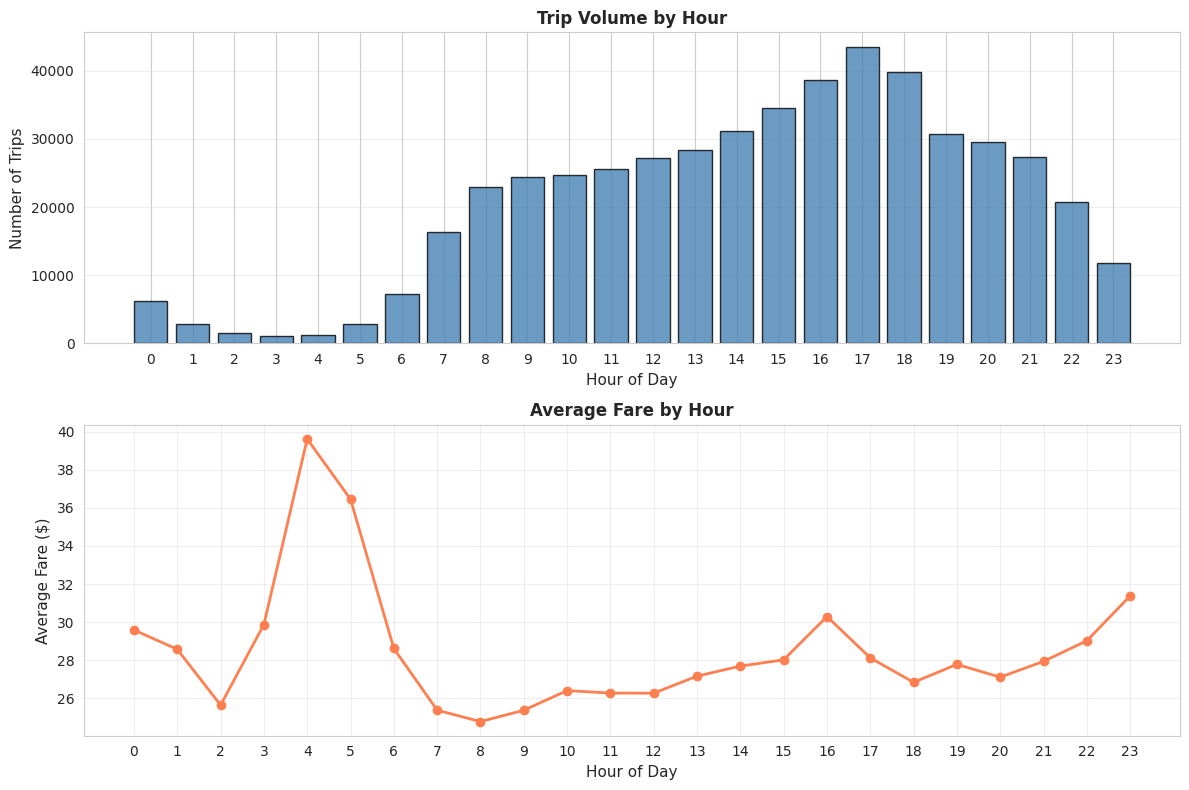


📊 Peak hour: 17:00
💰 Highest avg fare hour: 4:00


In [7]:
# Hourly Demand Patterns
hourly_stats = df_clean.group_by("pickup_hour").agg([
    pl.col("total_amount").mean().alias("avg_fare"),
    pl.col("total_amount").count().alias("trip_count")
]).sort("pickup_hour").to_pandas()

fig, axes = plt.subplots(2, 1, figsize=(12, 8))

# Trip count by hour
axes[0].bar(hourly_stats['pickup_hour'], hourly_stats['trip_count'], 
            color='steelblue', alpha=0.8, edgecolor='black')
axes[0].set_xlabel('Hour of Day', fontsize=11)
axes[0].set_ylabel('Number of Trips', fontsize=11)
axes[0].set_title('Trip Volume by Hour', fontsize=12, fontweight='bold')
axes[0].grid(alpha=0.3, axis='y')
axes[0].set_xticks(range(24))

# Average fare by hour
axes[1].plot(hourly_stats['pickup_hour'], hourly_stats['avg_fare'], 
             marker='o', linewidth=2, markersize=6, color='coral')
axes[1].set_xlabel('Hour of Day', fontsize=11)
axes[1].set_ylabel('Average Fare ($)', fontsize=11)
axes[1].set_title('Average Fare by Hour', fontsize=12, fontweight='bold')
axes[1].grid(alpha=0.3)
axes[1].set_xticks(range(24))

plt.tight_layout()
plt.show()

print(f"\n📊 Peak hour: {hourly_stats.loc[hourly_stats['trip_count'].idxmax(), 'pickup_hour']:.0f}:00")
print(f"💰 Highest avg fare hour: {hourly_stats.loc[hourly_stats['avg_fare'].idxmax(), 'pickup_hour']:.0f}:00")